<a href="https://colab.research.google.com/github/rluca96/Kernel-Perceptron-/blob/main/Machine_Learning_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

## Data Import & Preparation

In [ ]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline
import time as t
import timeit
from imp import reload

In [ ]:
#upload kaggle.json 

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rluca96","key":"c9253c5ac45d4f2f0cd7adc983c0e200"}'}

In [ ]:
#set directory 
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
#Download the forest cover dataset from kaggle using the json file uploaded before
!chmod 600 /content/kaggle.json
!kaggle datasets download -d oddrationale/mnist-in-csv

 59% 9.00M/15.2M [00:00<00:00, 13.1MB/s]
100% 15.2M/15.2M [00:00<00:00, 20.9MB/s]


In [ ]:
#unzip the file and remove the zip
!unzip \*.zip && rm *.zip  

Archive:  mnist-in-csv.zip
  inflating: mnist_test.csv          
  inflating: mnist_train.csv         


In [ ]:
data = pd.read_csv("mnist_test.csv")
data = data.sample(frac = 0.2, random_state= 123)
train = data.sample(frac=0.7, random_state = 123)
test = data.drop(train.index)

In [ ]:
y_train = train.iloc[:, 0]
X_train = train.iloc[:, 1:]
y_test = test.iloc[:, 0]
X_test = test.iloc[:,1:]

In [ ]:
index = np.random.RandomState(seed = 123).permutation(X_train.index)
X_train = X_train.reindex(index)
y_train = y_train[index]

In [ ]:
X_train.shape

(1400, 784)

#### Plots

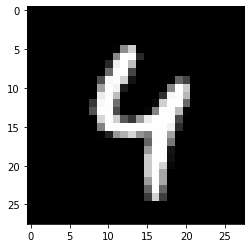

In [ ]:
sample = 1
image = X_train.iloc[sample]
pixels = np.array(image, dtype='uint8')
pixels = pixels.reshape((28, 28))
fig = plt.figure
plt.imshow(pixels, cmap='gray')
plt.show()

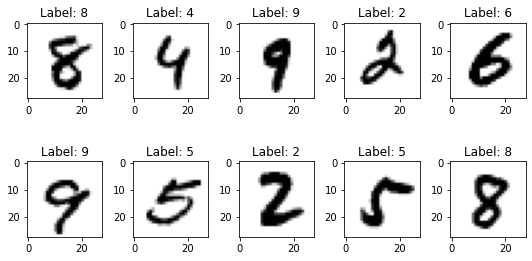

In [ ]:
num = 10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    pixels = np.array(X_train.iloc[i], dtype='uint8')
    pixels = pixels.reshape((28,28))
    ax.imshow(pixels, cmap='gray_r')
    ax.set_title('Label: {}'.format(y_train.iloc[i]))
plt.tight_layout()
plt.savefig('numbers.png')
plt.show()


## Perceptron kernel

In [ ]:
def poly(x1, x2, power):
  return (1+np.dot(x1,x2))**power

In [ ]:
def kernelMatrix(X1, X2, power):
  x1_samples = X1.shape[0]
  x2_samples = X2.shape[0]
  K = np.zeros((x1_samples, x2_samples))
  for i in range(x1_samples):
    for j in range(x2_samples):
      K[i,j] = poly(X1.iloc[i,:], X2.iloc[j,:], power)
  return K

In [ ]:
def symm_kernelMatrix(X, power): 
  n_samples = X.shape[0]
  K = np.zeros((n_samples, n_samples))
  for i in range(n_samples):
    for j in range(i, n_samples):
      K[i,j] = poly(X.iloc[i,:], X.iloc[j,:], power)
  K = K + K.T - np.diag(K.diagonal())
  return K

In [247]:
class KernelPerceptron(object):
  """"
  Kernel Perceptron Classifier

  Parameters
  -------------
  epoch: int
    number of epochs (iterations) over the training data
  
  Attributes
  -------------
  """
  def __init__(self, label, epoch):
    self.epoch = epoch
    self.label = label
  
  def set_label(self, y):
    return np.where(y == self.label, 1, -1)
  
  def fit_smallest(self, X_train, y_train, Kernel_Matrix = None):
    """"
    Fit method for training data

    Parameters
    ------------
    X: array, shape = [n_samples, n_features]
      is the feature set
    y: array, shape = [n_samples] 
      target value for the feature sets
    
    Attributes
    ------------
    alpha: array, shape = [n_samples]
      is the weight associated to each sample. 
    w: 1-d array holding the weights after fitting the model to the training data
    errors: list keeping track of the misclassification in every epoch
    Returns
    ------------
    self: object

    """
    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]
    alpha = np.zeros(n_samples)
    best_accuracy = -1
    y_train = self.set_label(y_train)
    self.errors = []
    
    for _ in range(self.epoch):
      error = 0
      for i in range(n_samples):
        y_hat = np.sign(np.sum(alpha*y_train*Kernel_Matrix[:, i]))
        if y_hat != y_train[i]:
          alpha[i] += 1
          error += 1
      accuracy = 1 - (float(error)/n_samples)
      print("epoch" + str(_) + ":" + str(accuracy))
      self.errors.append(error)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        smallest_alpha = alpha
        smallest_epoch = _
    print(best_accuracy, smallest_epoch)

    support_indexes = np.nonzero(smallest_alpha)
    self.saved_alpha = smallest_alpha[support_indexes]
    self.support_vector = X_train.iloc[support_indexes]
    self.support_vector_y = y_train[support_indexes]

  def fit_average(self, X_train, y_train, Kernel_Matrix = None):
    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]
    alpha = np.zeros(n_samples)
    y_train = self.set_label(y_train)
    error = 0
    ensemble = []
    for _ in range(self.epoch):
      for i in range(n_samples):
        y_hat = np.sign(np.sum(alpha*y_train*Kernel_Matrix[:, i]))
        if y_hat != y_train[i]:
          alpha[i] += 1 
      ensemble.append(alpha)

    ensemble = np.array(np.sum(ensemble, axis = 0)/(self.epoch+1))
    support_indexes = np.nonzero(ensemble)
    for k in range(n_samples):
      y_hat = np.sign(np.sum(ensemble*y_train*Kernel_Matrix[:, k]))
      if y_hat != y_train[k]:
        error +=1
    accuracy = 1 - (float(error)/n_samples)
    print(accuracy)
    self.saved_alpha = ensemble[support_indexes]
    self.support_vector = X_train.iloc[support_indexes]
    self.support_vector_y = y_train[support_indexes]
      
  def predict(self, X_test, power, Matrix_predict = None, toLabel = True):
    n_samples = X_test.shape[0]
    y_hat = np.zeros(n_samples)
    if Matrix_predict is None:
      Matrix_predict = kernelMatrix(X_test, self.support_vector, power)
    for i in range (n_samples):
        y_hat[i] = np.sum(self.saved_alpha*self.support_vector_y*Matrix_predict[i, :])
    
    return np.where(y_hat >= 0, self.label, -1) if toLabel else y_hat



In [246]:
class MulticlassKernelPerceptron(object):
  def __init__ (self, power, Matrix = None):
    self.power = power
    self.Matrix = Matrix
    self.perceptrons = []
    
  def fit_smallest(self, X_train, y_train, epoch = 11):
    for label in np.unique(y_train):
      self.perceptrons.append(KernelPerceptron(label, epoch))
    if self.Matrix is None:
      self.Matrix = symm_kernelMatrix(X_train, self.power)
    for kernel in self.perceptrons: 
      kernel.fit_smallest(X_train, y_train, self.Matrix)

  def fit_average(self, X_train, y_train, epoch = 11):
    for label in np.unique(y_train):
      self.perceptrons.append(KernelPerceptron(label, epoch))
    if self.Matrix is None:
      self.Matrix = symm_kernelMatrix(X_train, self.power)
    for kernel in self.perceptrons: 
      kernel.fit_average(X_train, y_train, self.Matrix)

  def predict(self, X_test, toLabel = False):
    y_hat_perceptrons = np.zeros((X_test.shape[0], len(self.perceptrons)))
    for i, kernel in enumerate(self.perceptrons):
      print(i)
      y_hat_perceptrons[:, i] = kernel.predict(X_test, self.power, toLabel = False)
    one_vs_all = np.argmax(y_hat_perceptrons, axis = 1) #y_hat è una matrixe con le y di ogni perceptron per colonna. axis = 1 prende il massimo sulla colonna per ogni prediction in ogni riga 
    return np.array([self.perceptrons[i].label for i in one_vs_all])

## Execution

In [ ]:
### Kernel Matrix time required
timer_matrix = []
for power in range(2,7):
  index = power - 2
  start = t.time()
  symm_kernelMatrix(X_train, power)
  timer_matrix.append(t.time()-start)
timer_matrix

[265.3615987300873,
 265.5399193763733,
 266.47379422187805,
 266.00312781333923,
 267.594970703125]

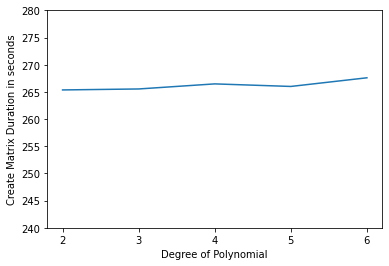

In [ ]:
plt.plot([2,3,4,5,6], timer_matrix)
plt.ylim(240, 280)
plt.xticks([2,3,4,5,6])
plt.ylabel("Create Matrix Duration in seconds")
plt.xlabel("Degree of Polynomial")
plt.savefig('matrix_duration.png')

In [ ]:
timer_matrix = [265.3615987300873,
 265.5399193763733,
 266.47379422187805,
 266.00312781333923,
 267.594970703125]

### Average

 #### Errors-Power

In [1]:
multiclassPerceptron = []
y_hat_power = np.zeros((5, X_test.shape[0]))
timer = []
for power in range(2,7):
  index = power - 2
  start = t.time()
  Kernel_Matrix = symm_kernelMatrix(X_train, power)
  matrix_time = t.time()-start
  start_fit = t.time()
  multiclassPerceptron.append(MulticlassKernelPerceptron(power, Kernel_Matrix))
  multiclassPerceptron[index].fit_average(X_train, y_train)
  fit_time = t.time()-start_fit
  start_predict = t.time()
  y_hat_power[index, :] = multiclassPerceptron[index].predict(X_test, power)
  predict_time = t.time()-start_predict
  timer.append((matrix_time, fit_time, predict_time))

NameError: ignored

In [ ]:
timer_df = pd.DataFrame(timer)
timer_df

,0,1,2
0,419.261204,3.357085,301.949887
1,411.892258,3.686250,1944.325879
2,412.444286,3.880628,2316.459309
3,402.516762,4.432863,2300.749491
4,412.818994,3.351929,2370.071158


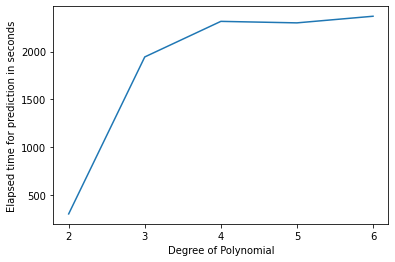

In [ ]:
plt.plot([2,3,4,5,6], timer_df[2])
plt.xticks([2,3,4,5,6])
plt.ylabel("Elapsed time for prediction in seconds")
plt.xlabel("Degree of Polynomial")
plt.savefig('prediction_duration.png')

In [ ]:
errors_power = []
accuracy_power = []
zero_one_power = []
#test for accuracy:
for i in range(y_hat_power.shape[0]):
  error = 0
  for y_hat_i, y_test_i in zip(y_hat_power[i], y_test):
    if y_hat_i != y_test_i:
      error += 1
  errors_power.append(error)
  accuracy_i = (1 - error/y_hat_power.shape[1])
  accuracy_power.append(accuracy_i)
  zero_one_power.append(error/y_hat_power.shape[1])
errors_power, accuracy_power, zero_one_power


([33, 592, 532, 533, 542],
 [0.945,
  0.013333333333333308,
  0.11333333333333329,
  0.11166666666666669,
  0.09666666666666668],
 [0.055,
  0.9866666666666667,
  0.8866666666666667,
  0.8883333333333333,
  0.9033333333333333])

#### Errors-Epochs

In [196]:
#### Average of Predictors
y_hat_epoch = np.zeros((10, X_test.shape[0]))
Kernel_Matrix = symm_kernelMatrix(X_train, power = 2)
multiclass_epoch = MulticlassKernelPerceptron(power = 2, Matrix = Kernel_Matrix)
for epoch in range(1,11):
  print("epoch " + str(epoch))
  index = epoch - 1
  multiclass_epoch.fit_average(X_train, y_train, epoch)
  y_hat_epoch[index, :] = multiclass_epoch.predict(X_test)
  multiclass_epoch.perceptrons = []

epoch 1
0.9921428571428571
0.9964285714285714
0.9814285714285714
0.975
0.9907142857142857
0.9857142857142858
0.9871428571428571
0.9864285714285714
0.9728571428571429
0.9757142857142858
0
1
2
3
4
5
6
7
8
9
epoch 2
0.9957142857142857
0.9992857142857143
0.9907142857142857
0.9892857142857143
0.9957142857142857
0.9964285714285714
0.995
0.9892857142857143
0.9685714285714285
0.9571428571428572
0
1
2
3
4
5
6
7
8
9
epoch 3
0.9985714285714286
0.9978571428571429
0.995
0.985
0.9964285714285714
0.9957142857142857
0.9957142857142857
0.9978571428571429
0.99
0.9928571428571429
0
1
2
3
4
5
6
7
8
9
epoch 4
1.0
1.0
0.9985714285714286
0.995
0.975
0.9992857142857143
0.995
0.9985714285714286
0.9814285714285714
0.9935714285714285
0
1
2
3
4
5
6
7
8
9
epoch 5
1.0
1.0
0.9957142857142857
0.9928571428571429
1.0
0.9971428571428571
0.9992857142857143
0.9957142857142857
1.0
0.9971428571428571
0
1
2
3
4
5
6
7
8
9
epoch 6
1.0
1.0
0.9942857142857143
1.0
1.0
0.9978571428571429
1.0
0.9992857142857143
1.0
0.98857142857142

In [195]:
errors_epoch = []
accuracy_epoch = []
zero_one_epoch = []
#test for accuracy:
for i in range(y_hat_epoch.shape[0]):
  error = 0
  for y_hat_i, y_test_i in zip(y_hat_epoch[i], y_test):
    if y_hat_i != y_test_i:
      error += 1
  errors_epoch.append(error)
  accuracy_i = (1 - error/y_hat_epoch.shape[1])
  accuracy_epoch.append(accuracy_i)
  zero_one_epoch.append(error/y_hat_epoch.shape[1])
errors_epoch, accuracy_epoch, zero_one_epoch

([50, 53, 42, 50, 43, 36, 41, 34, 33, 33],
 [0.9166666666666666,
  0.9116666666666666,
  0.9299999999999999,
  0.9166666666666666,
  0.9283333333333333,
  0.94,
  0.9316666666666666,
  0.9433333333333334,
  0.945,
  0.945],
 [0.08333333333333333,
  0.08833333333333333,
  0.07,
  0.08333333333333333,
  0.07166666666666667,
  0.06,
  0.06833333333333333,
  0.056666666666666664,
  0.055,
  0.055])

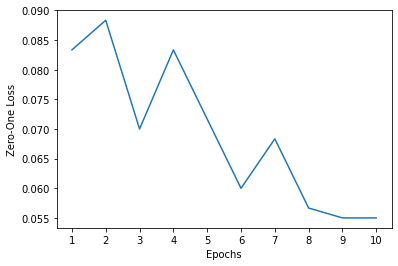

In [262]:
plt.plot([1,2,3,4,5,6,7,8,9,10], zero_one_epoch)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylabel("Zero-One Loss")
plt.xlabel("Epochs")
plt.savefig('epoch_zero_one.png')

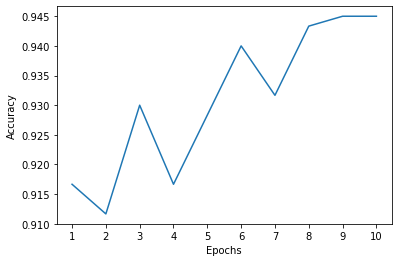

In [264]:
plt.plot([1,2,3,4,5,6,7,8,9,10], accuracy_epoch)
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.savefig('epoch_accuracy.png')

### Smallest Error

#### Errors-Power

In [215]:
multiclassPerceptron_small = []
y_hat_power_small = np.zeros((5, X_test.shape[0]))
prediction_timer = []
for power in range(2,7):
  index = power - 2
  Kernel_Matrix = symm_kernelMatrix(X_train, power)
  multiclassPerceptron_small.append(MulticlassKernelPerceptron(power, Kernel_Matrix))
  multiclassPerceptron_small[index].fit_smallest(X_train, y_train)
  prediction_start = t.time()
  y_hat_power_small[index, :] = multiclassPerceptron_small[index].predict(X_test, power)
  prediction_time = t.time()-prediction_start
  prediction_timer.append(prediction_time)

epoch0:0.965
epoch1:0.9914285714285714
epoch2:0.9885714285714285
epoch3:0.9992857142857143
epoch4:1.0
epoch5:1.0
epoch6:1.0
epoch7:1.0
epoch8:1.0
epoch9:1.0
1.0 4
epoch0:0.9771428571428571
epoch1:0.9957142857142857
epoch2:0.9971428571428571
epoch3:0.9971428571428571
epoch4:1.0
epoch5:1.0
epoch6:1.0
epoch7:1.0
epoch8:1.0
epoch9:1.0
1.0 4
epoch0:0.9442857142857143
epoch1:0.98
epoch2:0.9878571428571429
epoch3:0.9957142857142857
epoch4:0.9971428571428571
epoch5:0.9971428571428571
epoch6:0.995
epoch7:0.9971428571428571
epoch8:0.9992857142857143
epoch9:1.0
1.0 9
epoch0:0.9392857142857143
epoch1:0.9842857142857143
epoch2:0.9892857142857143
epoch3:0.9835714285714285
epoch4:0.9914285714285714
epoch5:0.9964285714285714
epoch6:1.0
epoch7:1.0
epoch8:1.0
epoch9:1.0
1.0 6
epoch0:0.9471428571428572
epoch1:0.9814285714285714
epoch2:0.99
epoch3:0.9928571428571429
epoch4:0.9985714285714286
epoch5:1.0
epoch6:1.0
epoch7:1.0
epoch8:1.0
epoch9:1.0
1.0 5
epoch0:0.9342857142857143
epoch1:0.9814285714285714
ep

In [255]:
errors_power_small = []
accuracy_power_small = []
zero_one_power_small = []
#test for accuracy:
for i in range(y_hat_power_small.shape[0]):
  error = 0
  for y_hat_i, y_test_i in zip(y_hat_power_small[i], y_test):
    if y_hat_i != y_test_i:
      error += 1
  errors_power_small.append(error)
  accuracy_i = (1 - error/y_hat_power_small.shape[1])
  accuracy_power_small.append(accuracy_i)
  zero_one_power_small.append(error/y_hat_power_small.shape[1])
errors_power_small, accuracy_power_small, zero_one_power_small

([33, 592, 532, 533, 542],
 [0.945,
  0.013333333333333308,
  0.11333333333333329,
  0.11166666666666669,
  0.09666666666666668],
 [0.055,
  0.9866666666666667,
  0.8866666666666667,
  0.8883333333333333,
  0.9033333333333333])

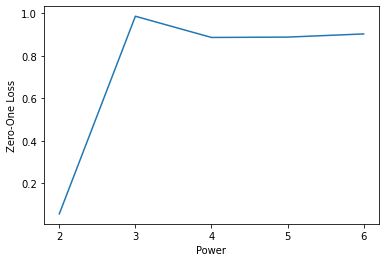

In [268]:
plt.plot([2,3,4,5,6], zero_one_power_small)
plt.xticks([2,3,4,5,6])
plt.ylabel("Zero-One Loss")
plt.xlabel("Power")
plt.savefig('power_zero_one.png')

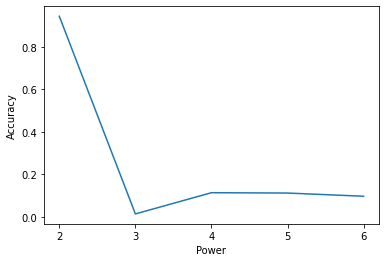

In [266]:
plt.plot([2,3,4,5,6], accuracy_power_small)
plt.xticks([2,3,4,5,6])
plt.ylabel("Accuracy")
plt.xlabel("Power")
plt.savefig('power_accuracy.png')

#### Errors-Epochs

In [267]:
y_hat_epoch_small = np.zeros((10, X_test.shape[0]))
#Kernel_Matrix = symm_kernelMatrix(X_train, power = 2)
multiclass_epoch_small = MulticlassKernelPerceptron(power = 2, Matrix = Kernel_Matrix)
for epoch in range(1,11):
  index = epoch - 1
  multiclass_epoch_small.fit_smallest(X_train, y_train, epoch)
  y_hat_epoch_small[index, :] = multiclass_epoch_small.predict(X_test)
  multiclass_epoch_small.perceptrons = []

epoch0:0.965
0.965 0
epoch0:0.9771428571428571
0.9771428571428571 0
epoch0:0.9442857142857143
0.9442857142857143 0
epoch0:0.9392857142857143
0.9392857142857143 0
epoch0:0.9471428571428572
0.9471428571428572 0
epoch0:0.9342857142857143
0.9342857142857143 0
epoch0:0.9585714285714286
0.9585714285714286 0
epoch0:0.9528571428571428
0.9528571428571428 0
epoch0:0.9057142857142857
0.9057142857142857 0
epoch0:0.9364285714285714
0.9364285714285714 0
0
1
2
3
4
5
6
7
8
9
epoch0:0.965
epoch1:0.9914285714285714
0.9914285714285714 1
epoch0:0.9771428571428571
epoch1:0.9957142857142857
0.9957142857142857 1
epoch0:0.9442857142857143
epoch1:0.98
0.98 1
epoch0:0.9392857142857143
epoch1:0.9842857142857143
0.9842857142857143 1
epoch0:0.9471428571428572
epoch1:0.9814285714285714
0.9814285714285714 1
epoch0:0.9342857142857143
epoch1:0.9814285714285714
0.9814285714285714 1
epoch0:0.9585714285714286
epoch1:0.99
0.99 1
epoch0:0.9528571428571428
epoch1:0.9764285714285714
0.9764285714285714 1
epoch0:0.905714285714

In [214]:
errors_epoch_small = []
accuracy_epoch_small = []
zero_one_epoch_small = []
#test for accuracy:
for i in range(y_hat_epoch_small.shape[0]):
  error = 0
  for y_hat_i, y_test_i in zip(y_hat_epoch_small[i], y_test):
    if y_hat_i != y_test_i:
      error += 1
  errors_epoch_small.append(error)
  accuracy_i = (1 - error/y_hat_epoch_small.shape[1])
  accuracy_epoch_small.append(accuracy_i)
  zero_one_epoch_small.append(error/y_hat_epoch_small.shape[1])
errors_epoch_small, accuracy_epoch_small, zero_one_epoch_small

([50, 53, 42, 50, 43, 36, 41, 34, 33, 33],
 [0.9166666666666666,
  0.9116666666666666,
  0.9299999999999999,
  0.9166666666666666,
  0.9283333333333333,
  0.94,
  0.9316666666666666,
  0.9433333333333334,
  0.945,
  0.945],
 [0.08333333333333333,
  0.08833333333333333,
  0.07,
  0.08333333333333333,
  0.07166666666666667,
  0.06,
  0.06833333333333333,
  0.056666666666666664,
  0.055,
  0.055])

## Simple Perceptron 

In [ ]:
class Perceptron(object):
  """"
  Perceptron Classifier

  Parameters
  -------------
  eta: float
    learning rate between 0 and 1
  epoch: int
    number of epochs (iterations) over the training data
  
  Attributes
  -------------
  w: 1-d array holding the weights after fitting the model to the training data
  errors: list keeping track of the misclassification in every epoch
  """
  def __init__(self, epoch=10):
    self.epoch = epoch
  
  def fit(self, X, y):
    """"
    Fit method for training data

    Parameters
    ------------
    X: array, shape = [n_samples, n_features]
      is the feature set
    y: array, shape = [n_samples] 
      target value for the feature sets
    
    Returns
    ------------
    self: object

    """
    self.w = np.zeros(1 + X.shape[1]) #1 + number of columns
    self.errors = [] #initialization

    for _ in range(self.epoch):
      errors = 0
      for xi, target in zip(X,y):
        update = target - self.predict(xi)
        self.w[1:] += update*xi #update weights for each feature
        self.w[0] += update
        errors += int(update != 0.0)
      self.errors.append(errors)
    return self

  def dot_prod(self, X):
    """"
    Calculate dot product
    """
    return np.dot(X, self.w[1:]) + self.w[0]
  
  def predict(self, X):
    """"
    returns the class labels after the dot product
    """
    return np.where(self.dot_prod(X) >= 0.0, 1, -1)




